# Predicting Hospital Discharge Outcomes

In this code, we will explore a dataset of patient hospital discharge outcomes as a function of the treatment they receive. We will then examine the business value of the predictive model for UVA Hospital. Finally, we learn how to use cost-sensitive training to maximize the business value of the predictive model.

## 1. Import packages

First, we will import our normal selection of packages. However, this time, we will be importing the classification version of the models we've been using. These will have different names, but generally, the parameters will be identical or nearly so.

In [1]:
import numpy as np # Library for math operations
import pandas as pd # Library for data handling
import sklearn # The machine learning library we will be using in this entire course
from sklearn import tree # Tree function is used for visualizing decision tree
from sklearn.metrics import * 
# Importing function that can be used to calculate different metrics
from sklearn.tree import DecisionTreeClassifier # Importing Decision Tree Classifier 
from sklearn.ensemble import RandomForestClassifier  # Importing Random Forest Classifier 
from sklearn.model_selection import train_test_split # Importing function that can split a dataset into training and testing set
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler # Importing function for scaling the data
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV # Importing GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier # Importing the XGBoost Classifier 
import matplotlib.pyplot as plt # Importing the package for plotting
plt.style.use('fivethirtyeight') # Use the styling from FiveThirtyEight Website
import seaborn as sns # Importing another package for plotting

from custom_functions import plot_conf_mat, plot_roc_curve, plot_feature_importance, calculateMetricsAndPrint

## 2. Load the Data

In [2]:
trainInput = pd.read_csv("DischargeTrain.csv")
testInput = pd.read_csv("DischargeTest.csv")

In [3]:
trainInput.head(2)

,Unique_Patient_Encounter_ID,Discharge_Type,Unique_Patient_ID,Sex,Marital_Status,Payment_Class,Previous_Discharge_Type,Age,ReadmissionCount,Diseases of the circulatory system-Cerebrovascular disease+Count*(sk_dim_dx),...,Subacute/SNF vs HHPT pending progress+First*(PTValue),Script given to CM+First*(PTValue),Long Term Acute Care Hospital+First*(PTValue),Home with nearly 24/7+First*(PTValue),Home with initial 24/7+First*(PTValue),Outpatient Cardiac rehab+First*(PTValue),Outpatient Pulmonary rehab+First*(PTValue),Hospice+First*(PTValue),AMPAC_Raw_Score,AMPAC_Scaled_Score
0,33434057,Home Health Agency,298873,Female,Single,Medicare Replacement,NaN,54,1,0,...,0,0,0,0,0,0,0,0,0,0
1,38150727,Infusion / Home,165661,Male,Divorced,Do not use,NaN,58,1,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
testInput.head(2)

,Unique_Patient_Encounter_ID,Discharge_Type,Unique_Patient_ID,Sex,Marital_Status,Payment_Class,Previous_Discharge_Type,Age,ReadmissionCount,Diseases of the circulatory system-Cerebrovascular disease+Count*(sk_dim_dx),...,Subacute/SNF vs HHPT pending progress+First*(PTValue),Script given to CM+First*(PTValue),Long Term Acute Care Hospital+First*(PTValue),Home with nearly 24/7+First*(PTValue),Home with initial 24/7+First*(PTValue),Outpatient Cardiac rehab+First*(PTValue),Outpatient Pulmonary rehab+First*(PTValue),Hospice+First*(PTValue),AMPAC_Raw_Score,AMPAC_Scaled_Score
0,37607139,Skilled Nursing Facility (SNF),227723,Female,Divorced,Medicare,NaN,89,0,10,...,0,0,0,0,0,0,0,0,18,0
1,34657024,Skilled Nursing Facility (SNF),188569,Female,Widowed,Medicare,NaN,80,0,0,...,0,0,0,0,0,0,0,0,16,0


Let's take a look at the shape of these dataframes.

In [5]:
trainInput.shape

(17435, 833)

In [6]:
testInput.shape

(5812, 833)

Before moving forward, we need to create our target variable. Our target variable should be equal to 1 if the discharge needs paperwork, and 0 otherwise. Let's take a look at the discharge types and then determine which ones require paperwork:

In [7]:
trainInput['Discharge_Type'].value_counts()

Home Health Agency                                        5696
HOME                                                      4790
Skilled Nursing Facility (SNF)                            3025
Acute Rehabilitation Facility (hospital or unit) (IRF)    1150
EXPIRED                                                    972
Infusion / Home                                            712
Long Term Care Hospital (LTCH)                             395
Hospice / Home                                             367
DIS TO LAW ENFORCE                                         166
AGAINST MED ADVICE                                         162
Name: Discharge_Type, dtype: int64

The types of discharge that require additional paperwork are `Skilled Nursing Facility (SNF)`, `Acute Rehabilitation Facility (hospital or unit) (IRF)`, and `Long Term Care Hospital (LTCH)`, so we will create a new variable which is `1` if any of those three are the discharge type or `0` if not.

In [8]:
trainInput['Requires_Paperwork'] = \
np.where(trainInput['Discharge_Type'].isin(['Skilled Nursing Facility (SNF)',
                                           'Acute Rehabilitation Facility (hospital or unit) (IRF)',
                                           'Long Term Care Hospital (LTCH)']),1,0)

trainInput['Requires_Paperwork'].value_counts()

0    12865
1     4570
Name: Requires_Paperwork, dtype: int64

In [9]:
testInput['Requires_Paperwork'] = \
np.where(testInput['Discharge_Type'].isin(['Skilled Nursing Facility (SNF)',
                                           'Acute Rehabilitation Facility (hospital or unit) (IRF)',
                                           'Long Term Care Hospital (LTCH)']),1,0)

testInput['Requires_Paperwork'].value_counts()

0    4267
1    1545
Name: Requires_Paperwork, dtype: int64

Now, we can go ahead and separate our x and y. Given that `Requires_Paperwork` is still fully correlated with our new y (`Requires_Paperwork`), we have to drop that as well. In addition, `Unique_Patient_Encounter_ID` and `Unique_Patient_ID` are unique identifiers and therefore there is no value in using them as predictors. So, we drop these columns too. Also, because our y values (labels) are already 0s and 1s, we don't need LabelEncode them anymore:

In [90]:
trainData = trainInput.drop(columns = ['Unique_Patient_Encounter_ID',
                                       'Unique_Patient_ID',
                                       'Requires_Paperwork',
                                      'Discharge_Type'])
trainLabels = trainInput.Requires_Paperwork

testData = testInput.drop(columns = ['Unique_Patient_Encounter_ID',
                                     'Unique_Patient_ID',
                                     'Requires_Paperwork',
                                      'Discharge_Type'])
testLabels = testInput.Requires_Paperwork

## 3. Data Augmentations

In [11]:
!pip install feature-engine

### 3.1. Treat Missing Values

Before starting the data augmentations, we need to check if we have any columns with missing values. If so, we need to process them first:

In [12]:
trainData.columns[trainData.isnull().any()].tolist()

['Previous_Discharge_Type']

In [13]:
testData.columns[testData.isnull().any()].tolist()

['Previous_Discharge_Type']

This column captures the previous discharge type if known. Given that many patients may not have a previous discharge status, or their previous discharge could be related to years ago, we just replace the missing values under this column with "Unkown":

In [91]:
from feature_engine.imputation import CategoricalImputer

imp = CategoricalImputer(imputation_method = 'missing',
                            fill_value = "Unknown")

trainData, testData = imp.fit_transform(trainData), imp.transform(testData)

In [80]:
trainData.Previous_Discharge_Type.value_counts()

Unknown                                                   14578
Home Health Agency                                         1311
Skilled Nursing Facility (SNF)                              880
Acute Rehabilitation Facility (hospital or unit) (IRF)      257
Infusion / Home                                             208
HOME                                                         68
DIS TO LAW ENFORCE                                           45
SNF / Rehab                                                  39
AGAINST MED ADVICE                                           21
Long Term Care Hospital (LTCH)                               18
Hospice / Home                                               10
Name: Previous_Discharge_Type, dtype: int64

In [81]:
testData.Previous_Discharge_Type.value_counts()

Unknown                                                   4893
Home Health Agency                                         421
Skilled Nursing Facility (SNF)                             266
Acute Rehabilitation Facility (hospital or unit) (IRF)      92
Infusion / Home                                             63
HOME                                                        33
DIS TO LAW ENFORCE                                          16
AGAINST MED ADVICE                                          13
SNF / Rehab                                                  8
Hospice / Home                                               6
Long Term Care Hospital (LTCH)                               1
Name: Previous_Discharge_Type, dtype: int64

### 3.2. Treat Rare Categories

In [92]:
from feature_engine.encoding import RareLabelEncoder

enc = RareLabelEncoder(tol=0.1, n_categories = 2)

trainData, testData = enc.fit_transform(trainData), enc.transform(testData)

The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent


In [83]:
trainData.Previous_Discharge_Type.value_counts()

Unknown    14578
Rare        2857
Name: Previous_Discharge_Type, dtype: int64

### 3.3. Drop Psudo-Constant Features (Small Variation)

In [93]:
from feature_engine.selection import DropConstantFeatures

con = DropConstantFeatures(tol=.95)

trainData, testData = con.fit_transform(trainData), con.transform(testData)

In [19]:
trainData.shape

(17435, 164)

### 3.4. Drop Correlated Columns

In [94]:
from feature_engine.selection import SmartCorrelatedSelection

sc = SmartCorrelatedSelection(threshold = .4)

trainData, testData = sc.fit_transform(trainData), sc.transform(testData)

In [21]:
trainData.shape

(17435, 118)

### 3.5. Treat Outliers

In [95]:
from feature_engine.outliers import Winsorizer

out = Winsorizer(tail = "both")

trainData, testData = out.fit_transform(trainData), out.transform(testData)

### 3.6. Remove the Remaining Redundant Features

Given that we have 800+ predictors in this data, we start with removing redundant features to decrease the number of predictors:

In [96]:
%%time
from feature_engine.selection import SelectByInformationValue

cor = SelectByInformationValue(threshold = .05)

trainData, testData = cor.fit_transform(trainData,trainLabels), cor.transform(testData)

CPU times: user 1.03 s, sys: 12.1 ms, total: 1.04 s
Wall time: 1.04 s


In [97]:
trainData.shape

(17435, 45)

### 3.7. Encode the Categorical Features

In [100]:
trainData.select_dtypes('object')

,Marital_Status,Payment_Class,Previous_Discharge_Type
0,Single,Rare,Unknown
1,Divorced,Rare,Unknown
2,Married,Rare,Unknown
3,Married,Rare,Unknown
4,Married,Medicare,Rare
...,...,...,...
17430,Married,Rare,Unknown
17431,Widowed,Medicare,Unknown
17432,Married,Medicare,Unknown
17433,Married,Blue Shield,Unknown


In [101]:
trainData.Marital_Status.unique()

array(['Single', 'Divorced', 'Married', 'Widowed', 'Rare'], dtype=object)

In [102]:
from feature_engine.encoding import WoEEncoder

enc = WoEEncoder()

trainData, testData = enc.fit_transform(trainData,trainLabels), enc.transform(testData)

In [103]:
trainData.Marital_Status.unique()

array([-0.2761477 ,  0.27778735, -0.21574944,  0.69993346, -0.28562802])

## 4. Train/ Evaluate The Classifier

In [104]:
xgb = XGBClassifier(random_state=0)
xgb.fit(trainData, trainLabels)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [105]:
predictedProbabilities = xgb.predict_proba(testData)
predictedLabels = xgb.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 88.04
PrecisionNegative: 90.08
PrecisionPositive: 81.34
RecallNegative: 94.07
RecallPositive: 71.39
AUC Score: 92.77



Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


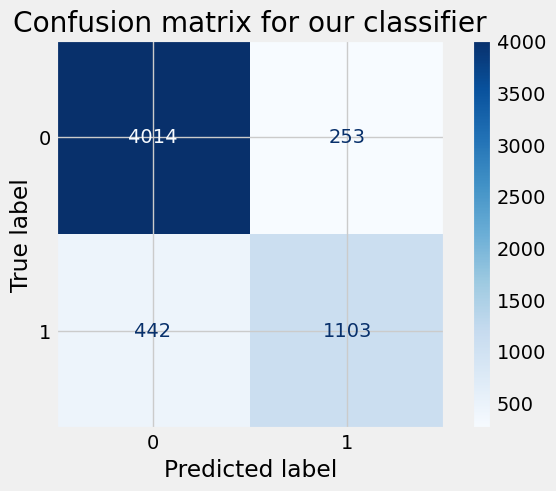

In [106]:
plot_conf_mat(xgb, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

In [30]:
testData.shape

(5812, 45)

## 5. Cost-benefit Analysis

So far, we built a predictive model-xgb (using XGBClassifier). Below, we use cost-benefit analysis to compare xgb and the status quo (no model). But before doing that, we need to determine the costs associated with FP and FN. 

In the case study, we read that it takes about four hours for a social worker to fill out UAI. We also learned that the average hourly rate to compensate the social workers is $18. Hence, the cost of filling out UAI will be:

$$ $18 * 4 = $72 $$

However, if UAI is needed for discharge, the patient needs to wait in the hospital for at least an additional four hours. In the case, we read that each additional day a patient stays in the hospital will cost 2,081 USD. This translates to 86.71 USD per hour. Hence, the additional four-hour stay will cost the hospital 

$$ $86.71 * 4 = $347 $$

If the staff fills out UAI before the discharge ticket is generated, this additional cost would be avoided.  


To sum up, we have the following information based on the case study and the data files in this notebook:

* Cost of each additional day in hospital: $2,081

* Cost of each additional hour in hospital: $86.71

* Time it takes to fill out UAI: 4 hours

* Social workers' hourly rate: $18

* Cost of filling out UAI: $72

* Additional hospital cost if UAI is completed after discharge recommendation triggered: $347

* Annual number of admitted patients: 28,539 

* Number of patients in testData: 5,812


Using this information, we can go ahead and conduct cost-benefit analysis. First, we estimate the cost or savings per cell in the confusion matrix:

|       | Predicted 0 | Predicted 1     |
| :---        |    :----:   |          ---: |
| Actual 0      | No cost      | 72 USD additional cost  |
| Actual 1   | 347 USD additional cost | No cost    |

Before comparing the two models, let's estimate the costs associated with two naive models: 

#### Scenario 1: No predictive model- predict no one needs UAI:

This is the status quo. In this scenario, every UAI will be filled only when the discharge recommendation is triggered. This is the equivalent of a naive model that predicts no one needs UAI. In this scenario, the confusion matrix will look like this:

|       | Predicted 0 | Predicted 1     |
| :---        |    :----:   |          ---: |
| Actual 0      | 4,455       | 0   |
| Actual 1   | 1,357       | 0      |

The cost associated with this model will be equal to:

In [31]:
1357 * 347

470879

This is the cost associated with 5,812 patients in testData. To estimate the total annual cost, we have to extrapolate this value for 28,539 annual patients:

In [32]:
1357 * 347 * (28539/5812)

2312184.408293186

We can see that the status quo costs about 2.3M USD for UVA Hospital. 

#### Scenario 2: No predictive model- predict everyone needs UAI:

In this scenario, the hospital staff members fill out UAI for every patient before the discharge recommendation is triggered:

|       | Predicted 0 | Predicted 1     |
| :---        |    :----:   |          ---: |
| Actual 0      | 0       | 4,455   |
| Actual 1   | 0       | 1,357      |

The cost will be equal to:

In [33]:
(4455 * 72) * (28539/5812)

1575046.3936682725

If UVA Hospital proactively fills out UAI for every patient, the cost will be about 700K USD, which is 1M USD less than the status quo.

#### Scenario 3: Predictive model- XGB Classifier:

Let's print the confusion matrix one more time:

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


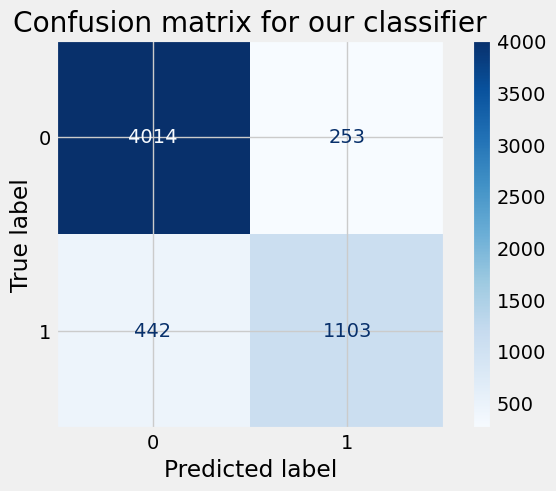

In [34]:
from custom_functions import plot_conf_mat, plot_roc_curve, plot_feature_importance, calculateMetricsAndPrint
plot_conf_mat(xgb, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

The cost will be equal to:

In [107]:
FP_Cost = (253 * 72) * (28539/5812)
FN_Cost = (442 * 347) * (28539/5812)

print("Total Cost = {}.".format(FP_Cost + FN_Cost))

Total Cost = 842568.3086717136.


Let's compare this value with the previous two values:

In [108]:
Scenario_1_3 = 2312184.408293186 - 842568.3086717136
print("Savings compared to scenario 1: {}".format(Scenario_1_3))

Savings compared to scenario 1: 1469616.0996214726


In [109]:
Scenario_2_3 = 1575046.3936682725 - 842568.3086717136
print("Savings compared to scenario 2: {}".format(Scenario_2_3))

Savings compared to scenario 2: 732478.084996559


### Your Task:

Use XGboost, LightGBM, CatBoost, or any other algorithm you prefer to build a cost-sensitive model. Then compare the savings of that model with scenario 1. 

This is a case competition. So please enter the highest savings into the leaderboard. The link will be shared in class. The highest amount of saving is the metric for this competition. 

**Tip- To be able to save more, you can:**

+ improve the predictive performance of the model (its ability to separate 0s and 1s). This can be done using different pre-processing steps/ methods, a different algorithm, and/ or optimizing the hyperparameters of the algorithm.

+ use different class weights as you train your models. 

+ decide/ change which matric (e.g., AUC, recall, accuracy, ...) should be used when optimizing the hyperparameters.

**Please enter the savings amount in leaderboardhq using the link provided below:**

Team 1:	https://leaderboardhq.com/addscore/qrfoujdr/s8sgq5ed 

Team 2:	https://leaderboardhq.com/addscore/qrfoujdr/ln1d20ff

Team 3:	https://leaderboardhq.com/addscore/qrfoujdr/ubfeiyfn

Team 4:	https://leaderboardhq.com/addscore/qrfoujdr/4hkmzxli 

Team 5:	https://leaderboardhq.com/addscore/qrfoujdr/pth24ax2 

Team 6:	https://leaderboardhq.com/addscore/qrfoujdr/8h2xc846

Team 7:	https://leaderboardhq.com/addscore/qrfoujdr/e2hpc7kb 

Team 8:	https://leaderboardhq.com/addscore/qrfoujdr/9woqtvvi

Team 9:	https://leaderboardhq.com/addscore/qrfoujdr/n39umthb

Team 10: https://leaderboardhq.com/addscore/qrfoujdr/mjd33pc7

Team 11: https://leaderboardhq.com/addscore/qrfoujdr/wcqy0773

Team 12: https://leaderboardhq.com/addscore/qrfoujdr/rxk986aj

### Rules:
1- Please use trainInput solely for training your models and testInput solely for testing them.

2- The confusion matrix in your solution should be based on testInput. Therefore, the costs are calculated based on the confusion matrix for testInput.

3- The evaluation metric is the total saving (higher is better). 

4- You can see the entire leaderboard here: https://leaderboardhq.com/qrfoujdr


Admin link (for Reza): https://leaderboardhq.com/7bkmch00